## Metadata and Annotations: Cleaning and Preprocessing

**Author**: Calvin Chan

**Data**: PTB-XL (https://physionet.org/content/ptb-xl/1.0.3/)

### Introduction
In this notebook we will go through the cleaning and preprocessing of our two additional CSV files `ptbxl_database.csv` and `scp_statements.csv`. These files contain patient information that go along with each ECG signal as well its diagnostic superclass (ECG  diagnosis) which we will be using for our project.

### Table of Contents
- [Data Dictionary](#dictionary)
- [Diagnostic Classes](#classes)
- [Procedures](#procedures)
- [Annotations](#annotations)
- [Metadata Cleaning](#metadata)
- [References](#references)

<a id='dictionary'></a>
### Data Dictionary
Here we present the data dictionaries for the two files in `PTB-XL` that we will be using. Metadata contains information about the patient who took the ECG while Annotation contains the standard SCP-ECG codes. Some of the descriptions are taken from or interpreted with the help of [Wagner et al. (2020)](#1).

- **Metadata file** (`ptbxl_database.csv`): 

| Column                       | Data Types | Description                                                     |
|------------------------------|------------|-----------------------------------------------------------------|
| patient_id                   | float      | Unique patient ID                                               |
| age                          | float      | Age in years                                                    |
| sex                          | integer    | Sex (M/F)                                                       |
| height                       | float      | Height in centimeters                                           |
| weight                       | float      | Weight in kilograms                                             |
| nurse                        | float      | Nurse that took the ECG (placeholder value)                     |
| site                         | float      | Site in which ECG was recorded                                  |
| device                       | string     | Device used to record ECG                                       |
| recording_date               | datetime   | Date time when ECG was recorded                                 |
| report                       | string     | Report by cardiologist or automatic intepretation by ECG device |
| scp_codes                    | dictionary | Standardized SCP-ECG statements                                 |
| heart_axis                   | string     | Hearts overall electrical activity direction                    |
| infarction_stadium1          | string     | First infarction stadium                                        |
| infarction_stadium2          | string     | Second infarction stadium                                       |
| validated_by                 | float      | Cardiologist that validated signal (placeholder value)          |
| second_opinion               | boolean    | Second opinion required                                         |
| initial_autogenerated_report | boolean    | Autogenerated report by ECG device                              |
| validated_by_human           | boolean    | Results validated by human                                      |
| baseline_drift               | string     | Leads with baseline drift                                       |
| static_noise                 | string     | Leads with static noise                                         |
| burst_noise                  | string     | Leads with burst noise                                          |
| electrodes_problems          | string     | Leads with electrode problem                                    |
| extra_beats                  | string     | Extra beats present                                             |
| pacemaker                    | string     | Pacemaker present in patient                                    |
| strat_fold                   | integer    | Suggested stratified folds for train test split                 |
| filename_lr                  | string     | Low sampling rate file path                                     |
| filename_hr                  | string     | High sampling rate file path                                    |

- **Annotation file** (`scp_statements.csv`): 

| Column                        | Data Types | Description                     |
|-------------------------------|------------|---------------------------------|
| description                   | string     | Annotation description          |
| diagnostic                    | float      | Related to diagnosis            |
| form                          | float      | Related to signal form          |
| rhythm                        | float      | Related to rhythm               |
| diagnostic_class              | string     | Superclass for diagnosis        |
| diagnostic_subclass           | string     | Subclass for diagnosis          |
| statement category            | string     | Medical description             |
| SCP-ECG statement description | string     | Official SCP-ECG description    |
| AHA code                      | float      | Unique AHA ID                   |
| aECG REFID                    | string     | Annotated ECG standard notation |
| CDISC code                    | string     | Controlled terminology          |
| DICOM code                    | string     | DICOM tags                      |


<a id='classes'></a>
### Diagnostic Classes

In general, ECG signals can show many conditions, however, for our simplicity we will categorize them into larger groups called superclasses. This is readily done in the annotation file where they categorized different conditions into five diagnostic superclasses:

| # Records | Superclass | Description            | Common Name                      |
|-----------|------------|------------------------|--------------------------------- |
| 9514      | NORM       | Normal ECG             | Normal                           |
| 5469      | MI         | Myocardial Infarction  | Heart Attack                     |
| 5235      | STTC       | ST/T Change            | Changes in ST Segment and T Wave |
| 4898      | CD         | Conduction Disturbance | Heart Blocks                     |
| 2649      | HYP        | Hypertrophy            | Enlarged Cardiac Muscles         |

> **Note**: The sum of the number of records here is more than the number of rows in the data because some ECG recordings show more than one condition.

<a id='procedures'></a>
### Procedures
Here we go through the general steps that we will perform throughout this notebook and the `ecg_cleaning` notebook as well.

1. Import diagnostics from annotation (`scp_statements.csv`) and add them to metadata (`ptbxl_database.csv`)   
    - Use `scp_code` column in metadata to get the diagnostic superclass
2. Clean metadata (can be done simultaneously with step 3)
    - Metadata `NaN` values
        - if rows dropped, need to drop corresponding signal too
3. Clean ECG signals 
    - Denoise using Fourier Transforms 
4. EDA 
    - Checking to see if there are any noticeable patterns for each diagnostic superclass

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import ast

%autosave 300

Autosaving every 300 seconds


<a id='annotations'></a>
### Annotations

For this section, we will look at the `scp_statements.csv` file which contains a list of statements called **Standard Communications Protocol for Computer Assisted Electrocardiography** (SCP-ECG). These are a set of standard formats for storing ECG data, metadata and annotations universally. In our metadata file (`ptbxl_database.csv`) we have a column that contains SCP codes, which is where we will extract the diagnosis of the corresponding ECG from using the list of statements. 

>**Note**: Some of the following code blocks in this section were taken from `example_physionet.py` included in the data set and can be found [here](https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py). 

Let's look at the SCP codes first in our metadata file:

In [2]:
# Load metadata file
path = '../data/physionet.org/files/ptb-xl/1.0.3/'

metadata = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  i

Since we have a lot of columns, by default Pandas would not show all of them. However, we can temporarily make it show all using the following code from [this](https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe) website.

In [4]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Metadata head:")
    display(metadata.head())
    print("Metadata tail:")
    display(metadata.tail())

Metadata head:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Metadata tail:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,"{'NORM': 100.0, 'SR': 0.0}",LAD,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
21837,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,"{'NORM': 100.0, 'SR': 0.0}",MID,NaN,NaN,1.0,False,True,True,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr


We can check for duplicated rows first. 


In [5]:
metadata.duplicated().sum()

0

As we can see there are no duplicated rows, as such we will move on to getting the annotations from `scp_statements.csv` on to our metadata file first. We will begin further analysis and cleaning in the next section of this notebook.

Let's focus on the `scp_codes` column and see how the values are interpreted by Pandas. 

In [6]:
metadata['scp_codes'].iloc[0]

"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"

We see that Pandas interprets the dictionaries in `scp_codes` as literal strings. This can by updated by applying the `literal_eval()` function from the `ast` library.

In [7]:
# Pandas probably read the scp_codes as strings, we can change them to be interpreted as dictionaries with ast
metadata['scp_codes'] = metadata['scp_codes'].apply(lambda x: ast.literal_eval(x)) 

In [8]:
metadata['scp_codes'].iloc[0]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

Now we see that the string got turned back into a dictionary and so we can use this column to tell us the diagnostic superclass for each ECG.

Let's load our annotation file now and see the kinds of SCP statements we have. 

In [9]:
annot = pd.read_csv(path + 'scp_statements.csv', index_col=0)

In [10]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, NDT to TRIGU
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    71 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           19 non-null     float64
 3   rhythm                         12 non-null     float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             71 non-null     object 
 7   SCP-ECG Statement Description  71 non-null     object 
 8   AHA code                       37 non-null     float64
 9   aECG REFID                     23 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     13 non-null     object 
dtypes: float64(4), object(8)
memory usage: 7.2+ KB


In [11]:
# Head and tail of data
print("Annotation head:")
display(annot.head())
print("Annotation tail:")
display(annot.tail())

Annotation head:


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


Annotation tail:


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
BIGU,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,1.0,NaN,NaN,Statements related to ectopic rhythm abnormali...,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,NaN,NaN
AFLT,atrial flutter,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,atrial flutter,51.0,MDC_ECG_RHY_ATR_FLUT,NaN,NaN
SVTAC,supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,supraventricular tachycardia,55.0,MDC_ECG_RHY_SV_TACHY,NaN,D3-31290
PSVT,paroxysmal supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,paroxysmal supraventricular tachycardia,NaN,MDC_ECG_RHY_SV_TACHY_PAROX,NaN,NaN
TRIGU,"trigeminal pattern (unknown origin, SV or Vent...",NaN,NaN,1.0,NaN,NaN,Statements related to ectopic rhythm abnormali...,"trigeminal pattern (unknown origin, SV or Vent...",NaN,NaN,NaN,NaN


Checking for duplicates:

In [12]:
# Checking for duplicates
annot.duplicated().sum()

0

Again without duplicates, we can move on to extracting SCP statements. 

Note that we are actually given that the annotations used in `metadata` are only present in `annot` where `diagnosis` = 1.0. Therefore we will only consider these rows by slicing our `annot` data frame. 

In [13]:
annot = annot[annot.diagnostic == 1]

In [14]:
annot

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


Using this new dataframe we can now scan through `metadata`, look at the dictionary keys in `scp_codes` and match with the corresponding index in `annot` which will allow us to extract the diagnostic superclass contained in the column `diagnostic_class`. Let's define a function that will do all of that for us called `get_diagnostic` and we will simply apply it to `metadata`.

In [15]:
def get_diagnostic(scp_code, annotation):
    """This function gets all the diagnostic superclasses in scp_code only if its likelihood is 100.0. The 
    result is a tuple that may contain more than one superclass. 
    
    Note: We are using tuples instead of list since tuples are hashable.
    """
    diag_list = []
    
    # Loop over the dictionary keys provided and append the superclasses to a list
    for key in scp_code.keys():
        
        # Find the corresponding superclass given the key
        if key in annotation.index and scp_code[key] == 100.0:
            diagnosis = annotation.loc[key]['diagnostic_class']
            diag_list.append(diagnosis)
    
    if len(diag_list) > 0:
        diag_list.sort()
    
    return tuple(set(diag_list))

def get_diagnostic_subclass(scp_code, annotation):
    """This function contains the same logic as get_diagnostic() except it obtains the diagnostic subclasses 
    for a given scp_code. The result is a tuple that may contain more than one subclass.
    
    Note: Again, we use tuples instead of lists because tuples are hashable.
    """
    diag_list = []
    
    # Loop over the dictionary keys provided 
    for key in scp_code.keys():
        
        # Find the corresponding subclass given the key
        if key in annotation.index and scp_code[key] == 100.0:
            diagnosis = annotation.loc[key]['diagnostic_subclass']
            diag_list.append(diagnosis)
    
    if len(diag_list) > 0:
        diag_list.sort()
        
    return tuple(set(diag_list))

Applying `get_diagnostic` to the column `scp_codes`, we will create a new column that will give us the diagnostic superclass for each ECG. 

In [16]:
# Apply get_diagnostic to our scp_codes column to obtain a new column called diagnostic_superclass
metadata['diagnostic_superclass'] = metadata['scp_codes'].apply(lambda x: get_diagnostic(x, annot))

In [17]:
# Sanity check 
metadata['diagnostic_superclass'].value_counts()

(NORM,)                7032
()                     4578
(CD,)                  2715
(STTC,)                2685
(MI,)                  1476
(MI, CD)                763
(STTC, HYP)             554
(STTC, CD)              531
(STTC, MI)              306
(HYP, CD)               207
(HYP,)                  204
(STTC, HYP, CD)         178
(NORM, CD)              138
(STTC, MI, HYP)         134
(STTC, MI, CD)          106
(STTC, MI, HYP, CD)      70
(MI, HYP, CD)            69
(MI, HYP)                51
(STTC, NORM, CD)          1
(HYP, NORM)               1
Name: diagnostic_superclass, dtype: int64

In [18]:
metadata.shape

(21799, 28)

As we can see we have a lot of empty lists, this is because they don't fall under any of the superclasses we have. Let's remove those rows first. 

In [19]:
metadata = metadata[metadata['diagnostic_superclass'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [20]:
metadata['diagnostic_superclass'].value_counts()

(NORM,)                7032
(CD,)                  2715
(STTC,)                2685
(MI,)                  1476
(MI, CD)                763
(STTC, HYP)             554
(STTC, CD)              531
(STTC, MI)              306
(HYP, CD)               207
(HYP,)                  204
(STTC, HYP, CD)         178
(NORM, CD)              138
(STTC, MI, HYP)         134
(STTC, MI, CD)          106
(STTC, MI, HYP, CD)      70
(MI, HYP, CD)            69
(MI, HYP)                51
(STTC, NORM, CD)          1
(HYP, NORM)               1
Name: diagnostic_superclass, dtype: int64

In [21]:
metadata.shape

(17221, 28)

We see that the empty rows got removed successfully. Next, we also want to get the diagnostic subclasses into our data set since we will also be filtering the signals that appear less than 20 times. To do this, we apply the `get_diagnostic_subclass` function we created above. 

In [22]:
# Apply get_diagnostic_subclass to get subclasses 
metadata['diagnostic_subclass'] = metadata['scp_codes'].apply(lambda x: get_diagnostic_subclass(x, annot))

In [23]:
# Sanity check 
print(metadata['diagnostic_subclass'].value_counts())

(NORM,)                                7032
(STTC,)                                1564
(AMI,)                                  641
(LAFB/LPFB,)                            604
(IRBBB,)                                602
                                       ... 
(LAO/LAE, _AVB, RAO/RAE, LAFB/LPFB)       1
(STTC, IVCD, IMI)                         1
(ISCI, ILBBB)                             1
(LAFB/LPFB, IVCD, AMI, IMI)               1
(ISCI, RAO/RAE)                           1
Name: diagnostic_subclass, Length: 465, dtype: int64


Now we want to filter out all the signals that are either an empty list in `diagnostic_superclass`, appears less than 20 times in `diagnostic_superclass`, or it appears less than 20 times in `diagnostic_subclass`. To do this, first let's accumulate a list of the subclasses that appear less than 20 times using the following block of code.

In [24]:
# Let's obtain the subclasses that appears less than 20 times
less_than_20 = tuple(metadata['diagnostic_subclass'].value_counts().index[
        metadata['diagnostic_subclass'].value_counts().values < 20
    ]
)

In [25]:
less_than_20

(('STTC', 'NST_'),
 ('AMI', 'CRBBB'),
 ('AMI', 'LVH'),
 ('_AVB', 'AMI', 'IMI'),
 ('ISC_', 'LVH', 'AMI', 'LAFB/LPFB'),
 ('LMI', 'AMI'),
 ('ISC_', 'IMI'),
 ('ISC_', 'IRBBB', 'LVH'),
 ('STTC', 'AMI'),
 ('LAO/LAE', '_AVB', 'CLBBB'),
 ('NORM', 'LAFB/LPFB'),
 ('LAO/LAE', '_AVB'),
 ('ISC_', 'STTC', 'LVH'),
 ('ILBBB',),
 ('ISCA', 'IRBBB'),
 ('ISCA', '_AVB'),
 ('LAO/LAE', 'STTC'),
 ('AMI', 'CRBBB', 'IMI'),
 ('ISC_', 'LAFB/LPFB'),
 ('ISC_', '_AVB', 'LVH'),
 ('_AVB', 'CRBBB'),
 ('NST_', 'LVH'),
 ('NST_', 'LAFB/LPFB'),
 ('ISC_', 'IVCD', 'IMI', 'LVH'),
 ('IVCD', 'LAFB/LPFB'),
 ('IRBBB', 'AMI', 'IMI'),
 ('IMI', 'CRBBB', 'LAFB/LPFB'),
 ('NST_', 'IVCD'),
 ('ISC_', 'IVCD'),
 ('LVH', 'LAFB/LPFB'),
 ('CRBBB', 'RVH'),
 ('IMI', 'LVH'),
 ('ISCI', 'IVCD'),
 ('LAFB/LPFB', '_AVB', 'AMI', 'IMI'),
 ('CRBBB', 'RVH', 'LAFB/LPFB'),
 ('IRBBB', 'RVH'),
 ('ISC_', 'ILBBB', 'LVH'),
 ('ILBBB', 'AMI'),
 ('LAFB/LPFB', 'AMI', 'IRBBB'),
 ('IVCD', 'LVH'),
 ('ISC_', 'LAO/LAE', 'LVH'),
 ('LAO/LAE', 'ISCA'),
 ('ISC_', 'IVCD', 'A

Next, removing the rows that are in `less_than_20`. 

In [26]:
metadata = metadata[metadata['diagnostic_subclass'].apply(
    lambda x: x not in less_than_20)].reset_index(drop=True)

In [27]:
# Sanity check
metadata.shape

(15890, 29)

Then, we will remove `diagnostic_superclass` that appear less than 100 times, since we want to train our model with sufficient amount of data. Let's pull out all of the classes that appear less than 100 times. 

In [28]:
# Let's obtain the superclasses that appears less than 100 times
less_than_100 = tuple(metadata['diagnostic_superclass'].value_counts().index[
        metadata['diagnostic_superclass'].value_counts().values < 100
    ]
)

In [29]:
less_than_100

(('STTC', 'MI', 'HYP'),
 ('STTC', 'HYP', 'CD'),
 ('HYP', 'CD'),
 ('STTC', 'MI', 'CD'))

Now we can filter our data with `less_than_100`. 

In [30]:
metadata = metadata[metadata['diagnostic_superclass'].apply(
    lambda x: x not in less_than_100)].reset_index(drop=True)

Taking a look at our two columns below, notice that our subclass only kept classes that appear 20 times or more and our superclass only has classes that appear more than 100 times. 

In [31]:
print(metadata['diagnostic_subclass'].value_counts())

(NORM,)                     7032
(STTC,)                     1564
(AMI,)                       641
(LAFB/LPFB,)                 604
(IRBBB,)                     602
(IMI,)                       568
(NST_,)                      436
(ISC_, LVH)                  422
(CLBBB,)                     389
(ISCA,)                      277
(IVCD,)                      260
(AMI, IMI)                   239
(AMI, LAFB/LPFB)             196
(ISC_,)                      181
(CRBBB,)                     179
(_AVB,)                      160
(LVH,)                       129
(CRBBB, LAFB/LPFB)           125
(ISCI,)                      102
(IRBBB, LAFB/LPFB)           100
(STTC, LAFB/LPFB)             86
(ISCA, AMI)                   81
(_AVB, CLBBB)                 74
(NORM, IRBBB)                 72
(ISCI, ISCA)                  69
(WPW,)                        65
(ISCA, LAFB/LPFB)             65
(ISCA, IMI)                   57
(STTC, _AVB)                  52
(STTC, IVCD)                  51
(STTC, IRB

In [32]:
print(metadata['diagnostic_superclass'].value_counts())

(NORM,)        7032
(STTC,)        2656
(CD,)          2653
(MI,)          1448
(MI, CD)        558
(STTC, HYP)     464
(STTC, CD)      328
(STTC, MI)      240
(HYP,)          186
(NORM, CD)      112
Name: diagnostic_superclass, dtype: int64


In [33]:
print(f"The total number of rows we have is {metadata['diagnostic_superclass'].value_counts().sum()}")

The total number of rows we have is 15677


In [34]:
metadata.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,diagnostic_subclass
0,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,"(NORM,)","(NORM,)"
1,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,"(NORM,)","(NORM,)"
2,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,"(NORM,)","(NORM,)"
3,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,"(NORM,)","(NORM,)"
4,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr,"(NORM,)","(NORM,)"


We see that we have successfully added the diagnostic superclasses in the annotation file to our metadata. From here on we can just focus on the metadata file. Let's drop the `scp_codes` since we already used it to get our diagnostics, as well as `diagnostic_subclass` since we already used it to filter our data. 

In [35]:
# Dropping scp_codes column
metadata.drop(columns='scp_codes', inplace=True)

# Dropping diagnostic_subclass column
metadata.drop(columns='diagnostic_subclass', inplace=True)

We also want to convert the tuples in `diagnostic_superclass` back to lists since they are easier to work with. 

In [36]:
# Convert superclass tuples back into lists
metadata['diagnostic_superclass'] = metadata['diagnostic_superclass'].apply(lambda x: list(x))

In [37]:
# Sanity check
metadata['diagnostic_superclass'].head()

0    [NORM]
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
Name: diagnostic_superclass, dtype: object

In [38]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    15677 non-null  float64
 1   age                           15677 non-null  float64
 2   sex                           15677 non-null  int64  
 3   height                        5058 non-null   float64
 4   weight                        7015 non-null   float64
 5   nurse                         14620 non-null  float64
 6   site                          15664 non-null  float64
 7   device                        15677 non-null  object 
 8   recording_date                15677 non-null  object 
 9   report                        15677 non-null  object 
 10  heart_axis                    9550 non-null   object 
 11  infarction_stadium1           3384 non-null   object 
 12  infarction_stadium2           66 non-null     object 
 13  v

<a id='metadata'></a>
### Metadata Cleaning

In this section we will clean the metadata.

In [39]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(metadata.head())
    display(metadata.tail())

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
1,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
2,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
3,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
4,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr,[NORM]


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
15672,11905.0,55.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 12:49:25,sinusrhythmus lagetyp normal normales ekg 4.46...,MID,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/21000/21831_lr,records500/21000/21831_hr,[NORM]
15673,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
15674,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
15675,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,LAD,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,[NORM]
15676,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,MID,NaN,NaN,1.0,False,True,True,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr,[NORM]


### Data Cleaning

Let's look at the data column by column to identify Nulls and see what we can do with them. 

#### `patient_id`

In [40]:
# Null values
metadata['patient_id'].isna().sum()

0

In [41]:
# Unique ids
metadata['patient_id'].value_counts()

9898.0     10
10107.0     8
15765.0     8
8304.0      7
18675.0     7
           ..
3610.0      1
6872.0      1
1866.0      1
6651.0      1
11744.0     1
Name: patient_id, Length: 14045, dtype: int64

We see that in `patient_id` there is a total of **15677 rows** but only **14045 unique patient_id**, that is there is only 14045 patients.

#### `age`

Let's look at age.

In [42]:
# Null values
metadata['age'].isna().sum()

0

In [43]:
# Unique age groups
metadata['age'].value_counts()

65.0    396
68.0    395
67.0    390
57.0    388
54.0    385
       ... 
12.0      2
2.0       1
4.0       1
6.0       1
7.0       1
Name: age, Length: 89, dtype: int64

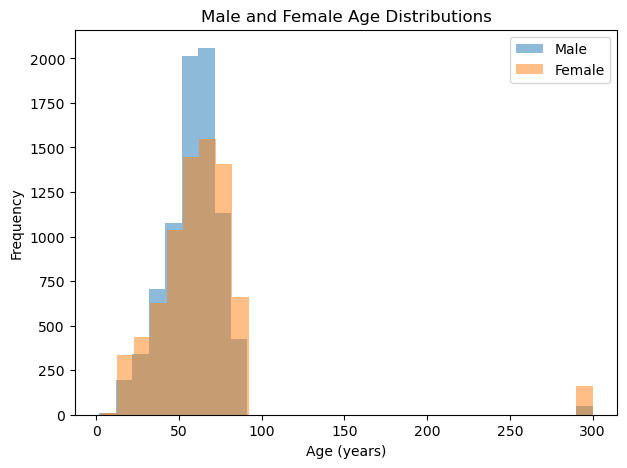

In [46]:
plt.figure(figsize=(7,5))
metadata.groupby('sex')['age'].plot(kind='hist', bins=30, alpha=0.5)
plt.title("Male and Female Age Distributions")
plt.xlabel("Age (years)")
plt.legend(['Male', 'Female'])
plt.show()

We also see that `age` does **not** contain any Null values and has **89 unique ages**.

#### `sex`
- Male: `0`
- Female: `1`

In [44]:
# Null values
metadata['sex'].isna().sum()

0

In [45]:
# Distribution
metadata['sex'].value_counts()

0    8009
1    7668
Name: sex, dtype: int64

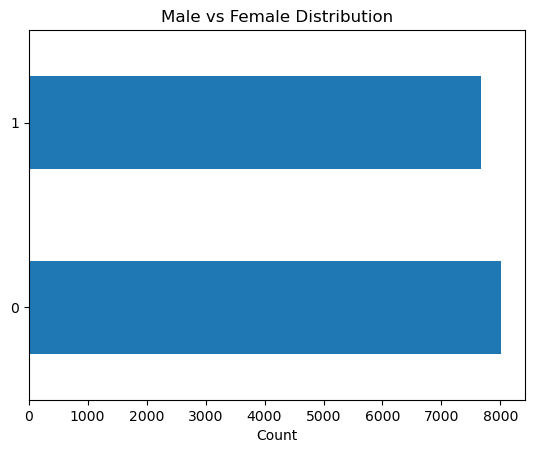

In [46]:
metadata['sex'].value_counts().plot(kind='barh')
plt.title('Male vs Female Distribution')
plt.xlabel('Count')
plt.show()

Again we can see that there are no Null values in the column `sex`.

#### `height`

Let's see how many Null values there are in `height`.

In [47]:
print("There are {} Null values in height: ".format(metadata['height'].isna().sum()))
print("{} of those are males".format(metadata[metadata['sex'] == 0]['height'].isna().sum()))
print("{} of those are females".format(metadata[metadata['sex'] == 1]['height'].isna().sum()))

There are 10619 Null values in height: 
5725 of those are males
4894 of those are females


Let's look at the distribution for male versus female and try to fill in those values. We can graphically compare the mean and median values of the height distribution of male versus female in our data and see which value to take to fill in our Null values. 

In [48]:
m_mean_height = round(metadata.groupby('sex')['height'].mean()[0], 1)
f_mean_height = round(metadata.groupby('sex')['height'].mean()[1], 1)

m_median_height = metadata.groupby('sex')['height'].median()[0]
f_median_height = metadata.groupby('sex')['height'].median()[1]

------Male Stats------
Mean Height: 173.3 cm
Median Height: 174.0 cm

-----Female Stats-----
Mean Height: 161.0 cm
Median Height: 160.0 cm


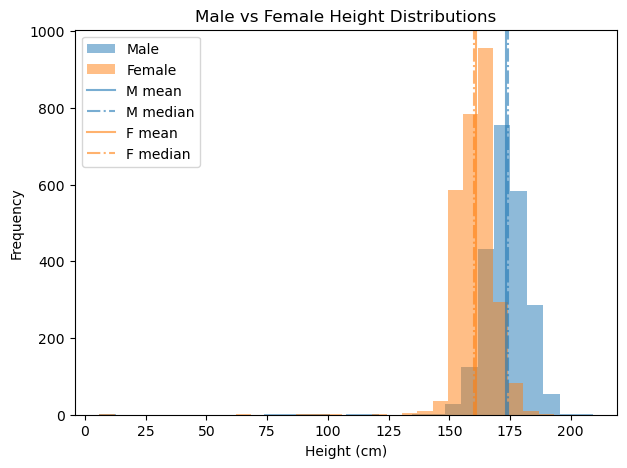

In [49]:
print("------Male Stats------")
print("Mean Height: {:.1f} cm".format(m_mean_height))
print("Median Height: {} cm". format(m_median_height))
print()
print("-----Female Stats-----")
print("Mean Height: {:.1f} cm".format(f_mean_height))
print("Median Height: {} cm".format(f_median_height))

plt.figure(figsize=(7,5))
metadata.groupby('sex')['height'].plot(kind='hist', bins=30, alpha=0.5)
plt.axvline(m_mean_height, c='C0', alpha=0.6)
plt.axvline(m_median_height, c='C0', ls='-.', alpha=0.6)
plt.axvline(f_mean_height, c='C1', alpha=0.6)
plt.axvline(f_median_height, c='C1', ls='-.', alpha=0.6)
plt.title("Male vs Female Height Distributions")
plt.xlabel("Height (cm)")
plt.legend(['Male', 'Female', 'M mean', 'M median', 'F mean', 'F median'])
plt.show()

Graphically, we see that male and female distributions separate look pretty normally distributed. We also see the mean and median values being pretty close to each other. As a result, let's fill in the Null values of male and female heights using their respective means. 

In [50]:
# Indices
m_index = (metadata['sex'] == 0) & (metadata['height'].isna())
f_index = (metadata['sex'] == 1) & (metadata['height'].isna())

# Fill 
metadata.loc[m_index, 'height'] = m_mean_height
metadata.loc[f_index, 'height'] = f_mean_height

In [51]:
# Sanity check
metadata['height'].isna().sum()

0

In [52]:
metadata.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,15709.0,56.0,1,161.0,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
1,20372.0,37.0,1,161.0,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
2,17014.0,24.0,0,173.3,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
3,17448.0,19.0,1,161.0,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
4,19005.0,18.0,1,161.0,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr,[NORM]


#### `weight`
We can do something similar as what we did with height for weight.

In [53]:
print("There are {} Null values in weight: ".format(metadata['weight'].isna().sum()))
print("{} of those are males".format(metadata[metadata['sex'] == 0]['weight'].isna().sum()))
print("{} of those are females".format(metadata[metadata['sex'] == 1]['weight'].isna().sum()))

There are 8662 Null values in weight: 
4818 of those are males
3844 of those are females


Let's look at the distribution between male and female again but for weight this time. 

In [48]:
m_mean_weight = round(metadata.groupby('sex')['weight'].mean()[0], 1)
f_mean_weight = round(metadata.groupby('sex')['weight'].mean()[1], 1)

m_median_weight = metadata.groupby('sex')['weight'].median()[0]
f_median_weight = metadata.groupby('sex')['weight'].median()[1]

------Male Stats------
Mean Weight: 78.5 kg
Median Weight: 77.0 kg

-----Female Stats-----
Mean Weight: 64.5 kg
Median Weight: 63.0 kg


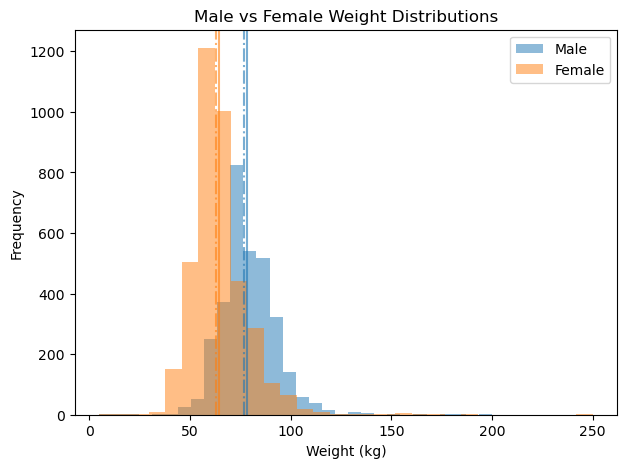

In [50]:
print("------Male Stats------")
print("Mean Weight: {:.1f} kg".format(m_mean_weight))
print("Median Weight: {} kg". format(m_median_weight))
print()
print("-----Female Stats-----")
print("Mean Weight: {:.1f} kg".format(f_mean_weight))
print("Median Weight: {} kg".format(f_median_weight))

plt.figure(figsize=(7,5))
metadata.groupby('sex')['weight'].plot(kind='hist', bins=30, alpha=0.5)
plt.axvline(m_mean_weight, c='C0', alpha=0.6)
plt.axvline(m_median_weight, c='C0', ls='-.', alpha=0.6)
plt.axvline(f_mean_weight, c='C1', alpha=0.6)
plt.axvline(f_median_weight, c='C1', ls='-.', alpha=0.6)
plt.title("Male vs Female Weight Distributions")
plt.xlabel("Weight (kg)")
#plt.legend(['Male', 'Female', 'M mean', 'M median', 'F mean', 'F median'])
plt.legend(['Male', 'Female'])
plt.savefig('sex_distribution.jpg')
plt.show()

Here we see some difference in between the mean and median weights for both male and female, therefore instead of using the mean value we will impute our Null values with the median. 

In [56]:
# Indices
m_index = (metadata['sex'] == 0) & (metadata['weight'].isna())
f_index = (metadata['sex'] == 1) & (metadata['weight'].isna())

# Fill 
metadata.loc[m_index, 'weight'] = m_median_weight
metadata.loc[f_index, 'weight'] = f_median_weight

In [57]:
# Sanity check
metadata['weight'].isna().sum()

0

In [58]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    15677 non-null  float64
 1   age                           15677 non-null  float64
 2   sex                           15677 non-null  int64  
 3   height                        15677 non-null  float64
 4   weight                        15677 non-null  float64
 5   nurse                         14620 non-null  float64
 6   site                          15664 non-null  float64
 7   device                        15677 non-null  object 
 8   recording_date                15677 non-null  object 
 9   report                        15677 non-null  object 
 10  heart_axis                    9550 non-null   object 
 11  infarction_stadium1           3384 non-null   object 
 12  infarction_stadium2           66 non-null     object 
 13  v

#### `nurse`, `site`, `device`, `recording`
Let's look at the next couple of columns together. We have `nurse`, `site`, `device`, and `recording_date`. We can look at the distribution for each of these columns using `value_counts()`.

In [59]:
# Nurse
metadata['nurse'].value_counts()

0.0     5888
1.0     4078
2.0      490
8.0      481
4.0      477
5.0      474
6.0      472
11.0     457
3.0      455
7.0      454
9.0      451
10.0     443
Name: nurse, dtype: int64

The `nurse` column seems to tell us which nurse took the ECG.

In [60]:
# Site
metadata['site'].value_counts()

0.0     6385
1.0     4583
2.0     3640
3.0      406
4.0       77
5.0       45
6.0       37
7.0       32
9.0       29
8.0       28
10.0      26
11.0      23
14.0      20
12.0      20
13.0      18
21.0      17
16.0      17
15.0      16
22.0      14
20.0      13
17.0      12
18.0      11
27.0      11
29.0      11
25.0      11
34.0      11
35.0      10
31.0       9
19.0       9
28.0       9
32.0       9
36.0       9
24.0       9
37.0       8
39.0       8
30.0       7
26.0       7
33.0       6
23.0       6
41.0       5
42.0       5
44.0       5
43.0       5
38.0       5
45.0       5
40.0       4
48.0       3
50.0       2
47.0       2
46.0       2
49.0       2
Name: site, dtype: int64

On the other hand, `site` is telling us which site the ECG was taken at. 

In [61]:
# Device
metadata['device'].value_counts()

CS100    3    4179
CS-12         2930
AT-6 C 5.5    2895
CS-12   E     2268
AT-6     6    1655
AT-60    3     662
AT-6 C 5.8     589
AT-6 C         358
AT-6 C 5.0      56
AT-6 C 5.3      49
AT-6 C 5.6      36
Name: device, dtype: int64

`device` represents the device model used to record the ECG.

In [62]:
# Recording date
metadata['recording_date'].value_counts()

1994-02-26 11:09:57    2
1992-02-06 11:47:42    2
1984-11-09 09:17:34    1
1995-07-11 09:17:45    1
1995-07-08 19:01:28    1
                      ..
1991-10-08 10:39:27    1
1991-10-08 14:13:38    1
1991-10-09 10:47:14    1
1991-10-09 12:06:15    1
2001-06-11 16:43:01    1
Name: recording_date, Length: 15675, dtype: int64

`recording_date` gives us the date in which the ECG was recorded.

Looking at the unique values for each of our columns, we see that it is mainly extra information about the process of taking the ECG and not information about the patient themselves. Either way this information is not useful for us towards predicting ECG superclass and so we will drop these columns.

In [63]:
# Dropping column `nurse` since it does not provide useful information to our model
metadata.drop(columns=['nurse', 'site', 'device', 'recording_date'], inplace=True)

In [64]:
# Sanity check
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(metadata.head())

,patient_id,age,sex,height,weight,report,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,15709.0,56.0,1,161.0,63.0,sinusrhythmus periphere niederspannung,NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
1,20372.0,37.0,1,161.0,69.0,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
2,17014.0,24.0,0,173.3,82.0,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
3,17448.0,19.0,1,161.0,70.0,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
4,19005.0,18.0,1,161.0,58.0,sinusrhythmus normales ekg,NaN,NaN,NaN,NaN,False,False,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr,[NORM]


### Statements

**Report**

In [65]:
metadata['report'].value_counts()

sinus rhythm. normal ecg.                                                                                                                                                                                                                    1719
sinusrhythmus lagetyp normal normales ekg                                                                                                                                                                                                    1263
sinusrhythmus lagetyp normal normales ekg 4.46                          unbestÄtigter bericht                                                                                                                                                1043
sinusrhythmus normales ekg                                                                                                                                                                                                                    687
trace only requested.           

Given that the data is composed of words and sentences and is also not in english, we can drop this column.

In [66]:
metadata.drop(columns='report', inplace=True)

#### `heart_axis`

In [67]:
metadata['heart_axis'].value_counts()

MID     5917
LAD     2265
ALAD    1088
RAD       98
ARAD      73
AXL       70
AXR       37
SAG        2
Name: heart_axis, dtype: int64

The heart axis describes the overall direction of electrical activity during the depolarization stage. It represents the heart’s electrical axis in the Cabrera system [[1](#1)]. It is used to help with diagnosing the ECG signal, however in our case, since we already have the diagnosis this information does not help us with our classification. Therefore, we will also drop this column. 

In [68]:
# Drop heart axis
metadata.drop(columns='heart_axis', inplace=True)

In [69]:
# Sanity check 
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    15677 non-null  float64
 1   age                           15677 non-null  float64
 2   sex                           15677 non-null  int64  
 3   height                        15677 non-null  float64
 4   weight                        15677 non-null  float64
 5   infarction_stadium1           3384 non-null   object 
 6   infarction_stadium2           66 non-null     object 
 7   validated_by                  8981 non-null   float64
 8   second_opinion                15677 non-null  bool   
 9   initial_autogenerated_report  15677 non-null  bool   
 10  validated_by_human            15677 non-null  bool   
 11  baseline_drift                1183 non-null   object 
 12  static_noise                  2358 non-null   object 
 13  b

#### `infarction_stadium1` and `infarction_stadium2`
Infarction stadium possibly refers to where there is a myocardial infarction detected in the ECG signal, when did it happen? Was it recently or long time ago. For further interpretation we can refer to a paper about the dataset found [here](#1).

In [70]:
# Count unique values 
metadata['infarction_stadium1'].value_counts()

unknown           2022
Stadium II-III     637
Stadium III        552
Stadium I          101
Stadium II          68
Stadium I-II         4
Name: infarction_stadium1, dtype: int64

In [71]:
# Count unique values 
metadata['infarction_stadium2'].value_counts()

Stadium III    38
Stadium II     15
Stadium I      13
Name: infarction_stadium2, dtype: int64

Since it does not provide valuable information to us we will drop them both. 

In [72]:
# Drop infarction_stadium1 and infarction_stadium2
metadata.drop(columns=['infarction_stadium1', 'infarction_stadium2'], inplace=True)

In [73]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    15677 non-null  float64
 1   age                           15677 non-null  float64
 2   sex                           15677 non-null  int64  
 3   height                        15677 non-null  float64
 4   weight                        15677 non-null  float64
 5   validated_by                  8981 non-null   float64
 6   second_opinion                15677 non-null  bool   
 7   initial_autogenerated_report  15677 non-null  bool   
 8   validated_by_human            15677 non-null  bool   
 9   baseline_drift                1183 non-null   object 
 10  static_noise                  2358 non-null   object 
 11  burst_noise                   425 non-null    object 
 12  electrodes_problems           17 non-null     object 
 13  e

#### `validated_by` and `second_opinion`
These ECGs were recorded and then validated by cardiologists, some of the results were verified by a second cardiologist. This is what the two columns `validated_by` and `second_opinion` represent. Since we do not need this information in our model, we can remove them.

In [74]:
# Dropping validated_by and second_opinion
metadata.drop(columns=['validated_by', 'second_opinion'], inplace=True)

In [75]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    15677 non-null  float64
 1   age                           15677 non-null  float64
 2   sex                           15677 non-null  int64  
 3   height                        15677 non-null  float64
 4   weight                        15677 non-null  float64
 5   initial_autogenerated_report  15677 non-null  bool   
 6   validated_by_human            15677 non-null  bool   
 7   baseline_drift                1183 non-null   object 
 8   static_noise                  2358 non-null   object 
 9   burst_noise                   425 non-null    object 
 10  electrodes_problems           17 non-null     object 
 11  extra_beats                   1211 non-null   object 
 12  pacemaker                     9 non-null      object 
 13  s

#### `initial_autogenerated_report` and `validated_by_human`
These two columns are just boolean columns letting us know if the report was autogenerated by an ECG device and whether the results were verified by a human cardiologist. As such we can also drop these columns too.

In [76]:
# Dropping initial_autogenerated_report and validated_by_human
metadata.drop(columns=['initial_autogenerated_report', 'validated_by_human'], inplace=True)

In [77]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             15677 non-null  float64
 1   age                    15677 non-null  float64
 2   sex                    15677 non-null  int64  
 3   height                 15677 non-null  float64
 4   weight                 15677 non-null  float64
 5   baseline_drift         1183 non-null   object 
 6   static_noise           2358 non-null   object 
 7   burst_noise            425 non-null    object 
 8   electrodes_problems    17 non-null     object 
 9   extra_beats            1211 non-null   object 
 10  pacemaker              9 non-null      object 
 11  strat_fold             15677 non-null  int64  
 12  filename_lr            15677 non-null  object 
 13  filename_hr            15677 non-null  object 
 14  diagnostic_superclass  15677 non-null  object 
dtypes:

### Signal Metadata
Now let's look at the columns associated with the signals themselves.

#### `baseline_drift` 
Baseline drift or baseline wandering are low frequency waveforms present in ECG signals. They are usually caused by movements of sorts such as breathing, moving while taking the ECG, or even improper placement of electrodes. We know that there are a lot of Null values in this column, this is most likely for signals where baseline wandering is not present. Let's take a look at our column to see what values we have. 

In [78]:
# Unique values
metadata['baseline_drift'].unique()

array([nan, ' , II,III,AVF', ' , III,AVR,AVF', ' , V1', ' , V3',
       ' , II-AVL,AVF', ' , III', ' , V6', ' , AVF', ' , II-AVF,V5,V6',
       ' , III,AVF', ' , II-AVF', ' , alles', ' , III,V3,V6', ' , I-AVR',
       ' , II-AVF,V5', ' , V5', ' , AVR', ' , II-V2', ' , V1V6',
       ' , II-V6', ' , V1 ', ' , AVL', ' , III,V4', ' , II,III,AVF-V6',
       ' , V5 ', ' , III,AVL', 'v5-6,  ', 'v2,  ', ' , V1,2', ' , 1',
       ' , III,V1', ' , V4,V5', ' , III,V3-V6', ' , V1-V3', ' , V4',
       ' , V2', ' , III,V5,V6', ' , I-AVF,V5,V6', ' , V1,V6',
       ' , I,II,AVR', ' , V5,V6', ' , I,III-V1', 'v5,  ', ' , v6',
       ' , I-AVF', ' , v2', ' , v4-6', 'v3,  ', 'v3, v1-6', ' , alle',
       ' , I,III,AVL,AVF', ' , I-AVL', ' , V1-V6', ' , III,AVF,V4',
       'v6,  ', ' , v3, v6', ' , I-AVL,AVF', ' , I,II,AVR,V1', ' , v1',
       'v3,6,  ', 'v2,3,  ', ' , V5,6', ' , 2', ' , V1,3,4,6', ' , v1,2',
       ' , v3', ' , II-AVL', ' , II-AVF,V6', ' , I,III,AVL', ' , V2-V5',
       ' , II,AVF', ' , V3

Notice that this column actually tells us whether or not baseline drift is present in the patient ECG and which lead(s) it appears in. This is useful information for us, especially when we are cleaning our ECG signals, therefore we will keep the column. However, for values present, we will clean the punctuation and whitespaces in before and after the words. 

In [79]:
import string 

def remove_ws_punc(x):
    """Given a comma separated sentence in string format, remove the punctuation and whitespaces before 
    and after the sentence. Return the sentence with commas between words still in place. 
    """
    punc = string.punctuation
    
    if pd.isna(x):
        return 0
    
    new_word = []
    x = x.lstrip(' ')
    for word in x.split(','):    
        if word not in punc:
            new_word.append(word)

    x = ','.join(new_word).strip(' ').strip(',')
        
    return x

In [80]:
l = [' , II,III,AVF', ' , III,AVR,AVF', ' , V1', ' , II,AVF']

for word in l:
    print(remove_ws_punc(word))

II,III,AVF
III,AVR,AVF
V1
II,AVF


In [81]:
# Apply function to baseline drift column
metadata['baseline_drift'] = metadata['baseline_drift'].apply(remove_ws_punc)

In [82]:
metadata['baseline_drift'].unique()

array([0, 'II,III,AVF', 'III,AVR,AVF', 'V1', 'V3', 'II-AVL,AVF', 'III',
       'V6', 'AVF', 'II-AVF,V5,V6', 'III,AVF', 'II-AVF', 'alles',
       'III,V3,V6', 'I-AVR', 'II-AVF,V5', 'V5', 'AVR', 'II-V2', 'V1V6',
       'II-V6', 'AVL', 'III,V4', 'II,III,AVF-V6', 'III,AVL', 'v5-6', 'v2',
       'V1,2', '1', 'III,V1', 'V4,V5', 'III,V3-V6', 'V1-V3', 'V4', 'V2',
       'III,V5,V6', 'I-AVF,V5,V6', 'V1,V6', 'I,II,AVR', 'V5,V6',
       'I,III-V1', 'v5', 'v6', 'I-AVF', 'v4-6', 'v3', 'v3, v1-6', 'alle',
       'I,III,AVL,AVF', 'I-AVL', 'V1-V6', 'III,AVF,V4', 'v3, v6',
       'I-AVL,AVF', 'I,II,AVR,V1', 'v1', 'v3,6', 'v2,3', 'V5,6', '2',
       'V1,3,4,6', 'v1,2', 'II-AVL', 'II-AVF,V6', 'I,III,AVL', 'V2-V5',
       'II,AVF', 'V3,V6', 'I,II,AVR,V2-V6', 'V5 stark!', 'II,III',
       'I,II,V3', 'V1,V2', 'V1,V4-V6', 'V3 stark', 'alle, alle', 'I-V1',
       'I-V6', 'v2,6', 'v1-6', 'II-V1', 'II-V4', 'drift', 'III,V6',
       'stark', 'I,II,V2,V3', 'I,III,AVL,V3', 'V2,3', 'II,AVF,V3-V6',
       'v4', 'v1,

#### `static_noise`

In [83]:
metadata['static_noise'].value_counts()

 , I-AVR,                     699
 , I-AVF,                     656
 , alles,                     371
 , I-V2,                      109
 , I-V1,                      103
                             ... 
 , mittel I,                    1
 , avl-iii, Stark,              1
 , Stark, noisy recording,      1
 , III-AVL,                     1
 , I-V1,V6,                     1
Name: static_noise, Length: 103, dtype: int64

This is also useful information to us when we are cleaning our ECG signals, so we will keep it for now and clean the puncutuations.

In [84]:
metadata['static_noise'] = metadata['static_noise'].apply(remove_ws_punc)

In [85]:
metadata['static_noise'].value_counts()

0                         13319
I-AVR                       699
I-AVF                       656
alles                       371
I-V2                        109
                          ...  
mittel I                      1
avl-iii, Stark                1
Stark, noisy recording        1
III-AVL                       1
I-V1,V6                       1
Name: static_noise, Length: 104, dtype: int64

In [86]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             15677 non-null  float64
 1   age                    15677 non-null  float64
 2   sex                    15677 non-null  int64  
 3   height                 15677 non-null  float64
 4   weight                 15677 non-null  float64
 5   baseline_drift         15677 non-null  object 
 6   static_noise           15677 non-null  object 
 7   burst_noise            425 non-null    object 
 8   electrodes_problems    17 non-null     object 
 9   extra_beats            1211 non-null   object 
 10  pacemaker              9 non-null      object 
 11  strat_fold             15677 non-null  int64  
 12  filename_lr            15677 non-null  object 
 13  filename_hr            15677 non-null  object 
 14  diagnostic_superclass  15677 non-null  object 
dtypes:

#### `burst_noise`
Burst noise are typically short in duration but high spikes in amplitude. We can see how much of our data is affected by this. 

In [87]:
print(f"Burst noise affects {metadata['burst_noise'].value_counts().sum()/metadata.shape[0]*100:.2f}% of our data.")

Burst noise affects 2.71% of our data.


We see that `burst_noise` does not affect much of our data and so we will disregard this column as well. Since we will be using Fourier Transforms to clean our signal, this should be taken care of. 

In [88]:
metadata.drop(columns='burst_noise', inplace=True)

#### `electrodes_problems`
Again, since this column only involves a very small portion of our data, we will ignore it and drop the column.

In [89]:
# Percentage of data affected by electrode problems
print(f"Electrodes problems affects {metadata['electrodes_problems'].value_counts().sum()/metadata.shape[0]*100:.2f}% of our data")

Electrodes problems affects 0.11% of our data


In [90]:
# Drop electrodes_problems
metadata.drop(columns='electrodes_problems', inplace=True)

In [91]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             15677 non-null  float64
 1   age                    15677 non-null  float64
 2   sex                    15677 non-null  int64  
 3   height                 15677 non-null  float64
 4   weight                 15677 non-null  float64
 5   baseline_drift         15677 non-null  object 
 6   static_noise           15677 non-null  object 
 7   extra_beats            1211 non-null   object 
 8   pacemaker              9 non-null      object 
 9   strat_fold             15677 non-null  int64  
 10  filename_lr            15677 non-null  object 
 11  filename_hr            15677 non-null  object 
 12  diagnostic_superclass  15677 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 1.6+ MB


#### `extra_beats`
We will also ignore this column, assuming that our models will not overfit to these noises.

In [92]:
metadata['extra_beats'].value_counts()

1ES            268
SVES           256
2ES             97
VES1,alles      96
VES             93
              ... 
7VES             1
2,V3             1
VES3,II-V3       1
SVES2,V1,V2      1
4ES,SVES         1
Name: extra_beats, Length: 96, dtype: int64

In [93]:
# Drop column
metadata.drop(columns='extra_beats', inplace=True)

In [94]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             15677 non-null  float64
 1   age                    15677 non-null  float64
 2   sex                    15677 non-null  int64  
 3   height                 15677 non-null  float64
 4   weight                 15677 non-null  float64
 5   baseline_drift         15677 non-null  object 
 6   static_noise           15677 non-null  object 
 7   pacemaker              9 non-null      object 
 8   strat_fold             15677 non-null  int64  
 9   filename_lr            15677 non-null  object 
 10  filename_hr            15677 non-null  object 
 11  diagnostic_superclass  15677 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.4+ MB


#### `pacemaker`
We will assume this column tells us whether or not the patient has a pacemaker. Let's look at the column values.

In [95]:
metadata['pacemaker'].value_counts()

ja, pacemaker    4
ja, nan          3
PACE????, nan    1
?, nan           1
Name: pacemaker, dtype: int64

We can do some feature engineering by converting all the columns that has pacemaker as True and ones without to False.

In [96]:
# Change Null values to 0
metadata['pacemaker'] = np.where(~metadata['pacemaker'].isna(), metadata['pacemaker'], 0)

In [97]:
# Change values with the word `pacemaker` in it to 1 and everything else 0
metadata['pacemaker'] = np.where(metadata['pacemaker'] == 'ja, pacemaker', 1, 0)

In [98]:
# Sanity check
metadata['pacemaker'].value_counts()

0    15673
1        4
Name: pacemaker, dtype: int64

#### `strat_fold`
Finally we can look at our last column `strat_fold`. Let's do a value counts.

In [99]:
metadata['strat_fold'].value_counts()

3     1606
7     1589
8     1584
6     1577
2     1571
10    1565
9     1562
4     1543
1     1542
5     1538
Name: strat_fold, dtype: int64

Looking through the documentation given by [Wagner et al. (2020)](#1), we find that `strat_fold` is a label encoding for the  data set where ECGs labeled with 9 or 10 have particularly higher label quality, intended to be used as validation set and test set respectively. This labeling was done based on existing multilabel stratification methods from the literature at the time this data set was published. As a result, we will keep this column and use it for when we perform train test split. 

### Export as CSV
Now we can export this new `metadata` file as a CSV for us to use it in our next notebook. 

In [100]:
metadata

,patient_id,age,sex,height,weight,baseline_drift,static_noise,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,15709.0,56.0,1,161.0,63.0,0,I-V1,0,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
1,20372.0,37.0,1,161.0,69.0,0,0,0,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
2,17014.0,24.0,0,173.3,82.0,"II,III,AVF",0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
3,17448.0,19.0,1,161.0,70.0,"III,AVR,AVF",0,0,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
4,19005.0,18.0,1,161.0,58.0,V1,0,0,4,records100/00000/00006_lr,records500/00000/00006_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...
15672,11905.0,55.0,1,161.0,63.0,0,0,0,9,records100/21000/21831_lr,records500/21000/21831_hr,[NORM]
15673,17180.0,67.0,1,161.0,63.0,0,alles,0,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
15674,20703.0,300.0,0,173.3,77.0,0,0,0,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
15675,8873.0,64.0,1,161.0,63.0,0,0,0,8,records100/21000/21836_lr,records500/21000/21836_hr,[NORM]


In [101]:
metadata.to_csv('../data/cleaned_metadata.csv')

### Conclusion
Having gone through the patient information data, we can move on to the ECG signals themselves for preprocessing and baseline modeling. This can be found in the `ecg_cleaning` notebook. 

<a id='references'></a>
## References

<a id='1'></a>
[1] Wagner, P., Strodthoff, N., Bousseljot, RD. et al. PTB-XL, a large publicly available electrocardiography dataset. Sci Data 7, 154 (2020). https://doi.org/10.1038/s41597-020-0495-6
<a id='2'></a>
[2] Śmigiel, S., Pałczyński, K., & Ledziński, D. (2021). ECG Signal Classification Using Deep Learning Techniques Based on the PTB-XL Dataset. Entropy (Basel, Switzerland), 23(9), 1121. https://doi.org/10.3390/e23091121